In [1]:
import csv
import pandas as pd
import xml.etree.ElementTree as ET
# The above three libraries are required to convert XML files from archive.org to CSV

from matplotlib import pyplot as plt
# Matplotlib for generating plots

In [ ]:
# The below three functions are defined to iteratively read the XML file and append it to CSV. Reference: https://stackoverflow.com/questions/68643683

def save_df(df, file_name, append=False):
    if append:
        df.to_csv(file_name, index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC, mode="a", header=False)
    else:
        df.to_csv(file_name, index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)    # With header for first iteration

def append_to_file(rows, output_csv_file, append):
    df = pd.DataFrame(rows)
    df.drop_duplicates("Id", inplace=True)             # Converting list (rows) to Pandas DataFrame and dropping duplicates if any
    save_df(df, output_csv_file, append=append)        # Passing to save DataFrame to CSV
    print("%d rows has been appended to the CSV file %s" % (len(df), output_csv_file))
    return len(df)

def convert_xml_to_csv_iteratively(XML_file, columns, output_csv_file, threshold):
    context = ET.iterparse(XML_file, events=("end",))
    
    total_posts = 0                                    # Defining variables
    unique_rows = 0
    rows = []
    current_count = 0    
    append = False
    
    for event, elem in context:
        if elem.tag == "row":                          # The XML tag name whose attribute values have data needed
            dic = {}
            for col in columns:                        # Iterating through columns passed to function
                dic[col] = elem.attrib.get(col, '')    # Get attribute value and add to dictionary
            rows.append(dic)                           # Appending dictionary to current list (rows)
            elem.clear()
            total_posts += 1
            current_count += 1
        if current_count > threshold:                  # Writing to CSV file at threshold value passed to function
            unique_rows +=  append_to_file(rows, output_csv_file, append)
            append = True
            current_count = 0
            rows = []                                  # Clearing current list (rows) for next iteration
    
    if(len(rows) > 0):                                 # Writing values after last threshold
        unique_rows += append_to_file(rows, output_csv_file, append)
    
    return total_posts

In [ ]:
# Downloaded archive, after extraction gave a 90.31 Gibibyte file "Posts.xml"
# It was sliced into smaller files using the bash "split" command
# The tail 4.31GiB were taken into analysis for 2021 data

# Converting Posts XML into CSV with required columns for analysis

convert_xml_to_csv_iteratively("Posts-4.31GiB.xml",
                               ["Id", "AcceptedAnswerId", "CreationDate", "Score", "ViewCount", "OwnerUserId", "Tags", "AnswerCount"],
                               "data/posts.csv",
                               99999)

In [ ]:
# Converting Users XML into CSV with required columns for analysis

convert_xml_to_csv_iteratively("Users.xml",
                               ["Id", "Reputation"],
                               "data/users.csv",
                               99999)

In [ ]:
# Reading CSV into Pandas DataFrame

posts_df = pd.read_csv("data/posts.csv")
users_df = pd.read_csv("data/users.csv")

# Merging posts_df and users_df DataFrame and saving to CSV

posts_df = posts_df.merge(users_df,left_on='OwnerUserId',right_on='Id')
posts_df.drop(["Id_y"], axis = 1, inplace = True)
posts_df.rename(columns = {"Id_x":"Id"}, inplace = True)
posts_df.sort_values(by=["Id"], inplace=True)
posts_df.to_csv("all_posts.csv", index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)

In [2]:
# Reading saved CSV into Pandas DataFrame for any new kernel session

posts_df = pd.read_csv("all_posts.csv")              # Base DataFrame with both Question and Answer posts

In [ ]:
# RQ1: TURNAROUND TIME

In [3]:
# Merging DataFrame with itself to get CreationDate of Accepted answer ID

QuesAns_df = posts_df.merge(posts_df,left_on="AcceptedAnswerId",right_on="Id")
QuesAns_df.rename(columns = {"Tags_x":"Tags"}, inplace = True)

In [4]:
# Defining a function to find the time difference between Accepted answer and Question CreationDate

import datetime

def time_diff(row):
    ques_date = row["CreationDate_x"]
    ans_date = row["CreationDate_y"]
    ques_date_obj = datetime.datetime.fromisoformat(ques_date)             # Converting to datetime object
    ans_date_obj = datetime.datetime.fromisoformat(ans_date)
    return (ans_date_obj - ques_date_obj).seconds

QuesAns_df["TurnaroundTime"] = QuesAns_df.apply(time_diff, axis=1)         # Applying function to all DataFrame rows

In [5]:
# Defining functions to get a boolean result if required tag is present in DataFrame row or not

def contains_tag(row, tag):
    all_tags = row["Tags"]
    return tag.lower() in all_tags.lower()

def contains_tag1(row):
    return contains_tag(row, "python")

def contains_tag2(row):
    return contains_tag(row, "c#")

QuesAns_df["Tag1?"] = QuesAns_df.apply(contains_tag1, axis=1)              # Applying function to all DataFrame rows
QuesAns_df["Tag2?"] = QuesAns_df.apply(contains_tag2, axis=1)

In [6]:
filter_tag1 = QuesAns_df["Tag1?"]                      # Boolean filters
filter_tag2 = QuesAns_df["Tag2?"]

q_accepted_ans1 = QuesAns_df[filter_tag1 & ~filter_tag2]       # Contains Tag1 and not Tag2 
q_accepted_ans2 = QuesAns_df[filter_tag2 & ~filter_tag1]       # Contains Tag2 and not Tag1

In [ ]:
q_accepted_ans1.CreationDate_x = pd.to_datetime(q_accepted_ans1.CreationDate_x)      # Converting to Pandas datetime format
q_accepted_ans2.CreationDate_x = pd.to_datetime(q_accepted_ans2.CreationDate_x)

# Grouping Questions by CreationDate with a frequency of 1 Week, then finding group mean turnaround time to plot

TAT_mean_tag1 = q_accepted_ans1.groupby([pd.Grouper(key="CreationDate_x", freq="W")])["TurnaroundTime"].mean().reset_index(name="TAT_mean")
TAT_mean_tag2 = q_accepted_ans2.groupby([pd.Grouper(key="CreationDate_x", freq="W")])["TurnaroundTime"].mean().reset_index(name="TAT_mean")

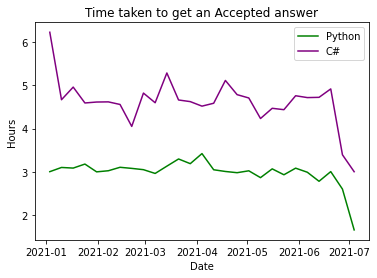

In [8]:
# Using Matplotlib

plt.title("Time taken to get an Accepted answer")
plt.xlabel("Date")
plt.ylabel("Hours")

# Dividing TAT_mean by 3600 to convert seconds into hours

plt.plot(TAT_mean_tag1["CreationDate_x"], TAT_mean_tag1["TAT_mean"]/3600, c = "green", label = "Python")
plt.plot(TAT_mean_tag2["CreationDate_x"], TAT_mean_tag2["TAT_mean"]/3600, c = "purple", label = "C#")

plt.legend()
plt.savefig("plots/turnaround time.jpg", dpi=300)

In [ ]:
# Null tags were not dropped earlier, as Accepted answer ID is untagged and its CreationDate was needed for above analysis

q_all = posts_df
q_all = q_all.dropna(subset = ["Tags"])                # Dropping Null tags

q_all["Tag1?"] = q_all.apply(contains_tag1, axis=1)    # Applying function contains_tag1 defined above to all DataFrame rows
q_all["Tag2?"] = q_all.apply(contains_tag2, axis=1)

filter_tag1 = q_all["Tag1?"]                           # Boolean filters
filter_tag2 = q_all["Tag2?"]

q_all1 = q_all[filter_tag1 & ~filter_tag2]             # Contains Tag1 and not Tag2
q_all2 = q_all[filter_tag2 & ~filter_tag1]             # Contains Tag2 and not Tag1

In [10]:
# Saving filtered DataFrames as CSV

q_all1.to_csv("posts_python.csv", index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)
q_all2.to_csv("posts_c#.csv", index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)

In [ ]:
# RQ2: NUMBER OF QUESTIONS ASKED PER DAY

In [11]:
# Defining from previously filtered DataFrame of all Questions with required tags

QNum_df_tag1 = q_all1
QNum_df_tag2 = q_all2

In [ ]:
QNum_df_tag1.CreationDate = pd.to_datetime(QNum_df_tag1.CreationDate)      # Converting to Pandas datetime format
QNum_df_tag2.CreationDate = pd.to_datetime(QNum_df_tag2.CreationDate)

# Grouping Questions by CreationDate with a frequency of 1 Day, then finding size of the groups to plot

QNum_mean_tag1 = QNum_df_tag1.groupby([pd.Grouper(key="CreationDate", freq="D")]).size().reset_index(name="QNum_mean")
QNum_mean_tag2 = QNum_df_tag2.groupby([pd.Grouper(key="CreationDate", freq="D")]).size().reset_index(name="QNum_mean")

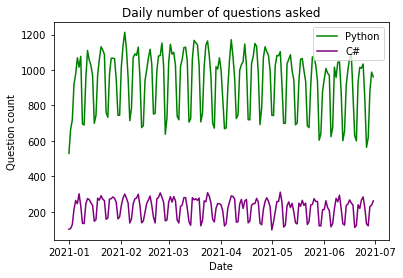

In [13]:
# Line plot using Matplotlib

plt.title("Daily number of questions asked")
plt.xlabel("Date")
plt.ylabel("Question count")

plt.plot(QNum_mean_tag1["CreationDate"], QNum_mean_tag1["QNum_mean"], c = "green", label = "Python")
plt.plot(QNum_mean_tag2["CreationDate"], QNum_mean_tag2["QNum_mean"], c = "purple", label = "C#")

plt.legend()
plt.savefig("plots/question count.jpg", dpi=300)

In [ ]:
# RQ3: REPUTATION SCORE

In [14]:
# Defining from previously filtered DataFrame of all Questions with required tags

Rep_df_tag1 = q_all1
Rep_df_tag2 = q_all2

In [ ]:
# Defining functions to remove outliers as some contributors might have a very high Reputation score

import numpy as np

def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn, [25,75])         # Calculating quartiles
    IQR = Q3 - Q1                                      # Interquartile range
    lower_range = Q1 - (1.5 * IQR)                     # Setting lowerbound and upperbound
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

def iqr_slice(df, column_name):
    lowerbound, upperbound = outlier_treatment(df[column_name])
    
    # Dropping DataFrame rows with Reputation value less than lowerbound and greater than upperbound
    df.drop(df[(df[column_name] > upperbound) | (df[column_name] < lowerbound)].index, inplace=True)
    
    return df

Rep_df_tag1 = iqr_slice(Rep_df_tag1, "Reputation")     # Applying function to all DataFrame rows
Rep_df_tag2 = iqr_slice(Rep_df_tag2, "Reputation")

In [ ]:
Rep_df_tag1.CreationDate = pd.to_datetime(Rep_df_tag1.CreationDate)        # Converting to Pandas datetime format
Rep_df_tag2.CreationDate = pd.to_datetime(Rep_df_tag2.CreationDate)

# Grouping Questions by CreationDate with a frequency of 1 Day, then finding group mean Reputation score to plot

Rep_mean_tag1 = Rep_df_tag1.groupby([pd.Grouper(key="CreationDate", freq="D")])["Reputation"].mean().reset_index(name="Rep_mean")
Rep_mean_tag2 = Rep_df_tag2.groupby([pd.Grouper(key="CreationDate", freq="D")])["Reputation"].mean().reset_index(name="Rep_mean")

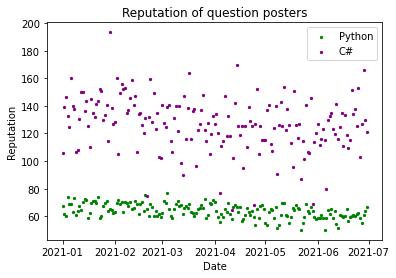

In [17]:
# Scatter plot using Matplotlib

plt.title("Reputation of question posters")
plt.xlabel("Date")
plt.ylabel("Reputation")

plt.scatter(Rep_mean_tag1["CreationDate"], Rep_mean_tag1["Rep_mean"], c = "green", s=5, label = "Python")
plt.scatter(Rep_mean_tag2["CreationDate"], Rep_mean_tag2["Rep_mean"], c = "purple", s=5, label = "C#")

plt.legend()
plt.savefig("plots/reputation of question posters.jpg", dpi=300)

In [ ]:
# RQ4: RATIO OF ACCEPTED ANSWERS TO TOTAL ANSWERS

In [18]:
# Defining from previous DataFrame of only Questions with an Accepted answer

AnsAccept_df_tag1 = q_accepted_ans1
AnsAccept_df_tag2 = q_accepted_ans2

In [ ]:
AnsAccept_df_tag1.CreationDate_x = pd.to_datetime(AnsAccept_df_tag1.CreationDate_x)  # Converting to Pandas datetime format
AnsAccept_df_tag2.CreationDate_x = pd.to_datetime(AnsAccept_df_tag2.CreationDate_x)

# Grouping Questions by CreationDate with a frequency of 1 Week, then finding group mean Answer count to plot

AnsAccept_mean_tag1 = AnsAccept_df_tag1.groupby([pd.Grouper(key="CreationDate_x", freq="W")])["AnswerCount_x"].mean().reset_index(name="AnswerCount_mean")
AnsAccept_mean_tag2 = AnsAccept_df_tag2.groupby([pd.Grouper(key="CreationDate_x", freq="W")])["AnswerCount_x"].mean().reset_index(name="AnswerCount_mean")

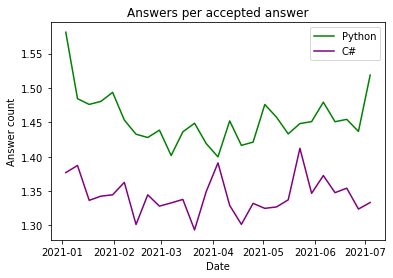

In [20]:
# Line plot using Matplotlib

plt.title("Answers per accepted answer")
plt.xlabel("Date")
plt.ylabel("Answer count")

plt.plot(AnsAccept_mean_tag1["CreationDate_x"], AnsAccept_mean_tag1["AnswerCount_mean"], c = "green", label = "Python")
plt.plot(AnsAccept_mean_tag2["CreationDate_x"], AnsAccept_mean_tag2["AnswerCount_mean"], c = "purple", label = "C#")

plt.legend()
plt.savefig("plots/answers per accepted answer.jpg", dpi=300)

In [ ]:
# RQ5: RATIO OF ANSWERS POSTED TO QUESTION VIEWS

In [21]:
# Defining from previously filtered DataFrame of all Questions with required tags

ViewsAns_df_tag1 = q_all1
ViewsAns_df_tag2 = q_all2

In [ ]:
ViewsAns_df_tag1["ViewsToAnswerRatio"] = ViewsAns_df_tag1["AnswerCount"] / ViewsAns_df_tag1["ViewCount"]
ViewsAns_df_tag2["ViewsToAnswerRatio"] = ViewsAns_df_tag2["AnswerCount"] / ViewsAns_df_tag2["ViewCount"]

In [ ]:
ViewsAns_df_tag1.CreationDate = pd.to_datetime(ViewsAns_df_tag1.CreationDate)        # Converting to Pandas datetime format
ViewsAns_df_tag2.CreationDate = pd.to_datetime(ViewsAns_df_tag2.CreationDate)

# Grouping Questions by CreationDate with a frequency of 1 Day, then finding group mean Ratio to plot

ViewsAns_mean_tag1 = ViewsAns_df_tag1.groupby([pd.Grouper(key="CreationDate", freq="D")])["ViewsToAnswerRatio"].mean().reset_index(name="VARatio_mean")
ViewsAns_mean_tag2 = ViewsAns_df_tag2.groupby([pd.Grouper(key="CreationDate", freq="D")])["ViewsToAnswerRatio"].mean().reset_index(name="VARatio_mean")

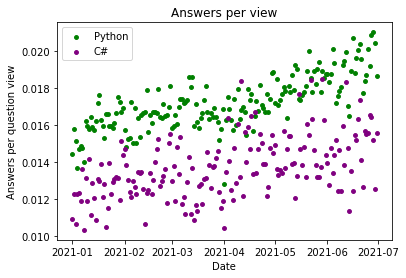

In [24]:
# Scatter plot using Matplotlib

plt.title("Answers per view")
plt.xlabel("Date")
plt.ylabel("Answers per question view")

plt.scatter(ViewsAns_mean_tag1["CreationDate"], ViewsAns_mean_tag1["VARatio_mean"], c = "green", s=15, label = "Python")
plt.scatter(ViewsAns_mean_tag2["CreationDate"], ViewsAns_mean_tag2["VARatio_mean"], c = "purple", s=15, label = "C#")

plt.legend()
plt.savefig("plots/answers per question view.jpg", dpi=300)

In [ ]:
# ADDITIONAL METRIC FOR RQ4 AND RQ5

In [25]:
# Defining from previously filtered DataFrame of all Questions with required tags

Score_df_tag1 = q_all1
Score_df_tag2 = q_all2

In [ ]:
Score_df_tag1.CreationDate = pd.to_datetime(Score_df_tag1.CreationDate)    # Converting to Pandas datetime format
Score_df_tag2.CreationDate = pd.to_datetime(Score_df_tag2.CreationDate)

# Grouping Questions by CreationDate with a frequency of 1 Week, then finding group mean Score to plot

Score_mean_tag1 = Score_df_tag1.groupby([pd.Grouper(key="CreationDate", freq="W")])["Score"].mean().reset_index(name="Score_mean")
Score_mean_tag2 = Score_df_tag2.groupby([pd.Grouper(key="CreationDate", freq="W")])["Score"].mean().reset_index(name="Score_mean")

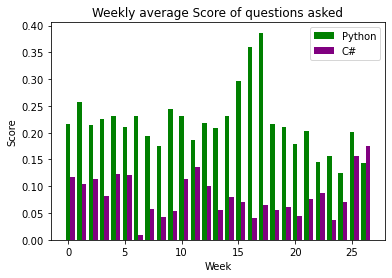

In [27]:
# Bar plot using Matplotlib

plt.title("Weekly average Score of questions asked")
plt.xlabel("Week")
plt.ylabel("Score")

r = np.arange(len(Score_mean_tag1))
width = 0.4

plt.bar(r, Score_mean_tag1["Score_mean"], 0.4, color="green", label = "Python")
plt.bar(r + width, Score_mean_tag2["Score_mean"], 0.4, color="purple", label = "C#")

plt.legend()
plt.savefig("plots/question score.jpg", dpi=300)